# Map 4 - Folds

This map is from Bennison et al. (2011). It contains two folds. First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

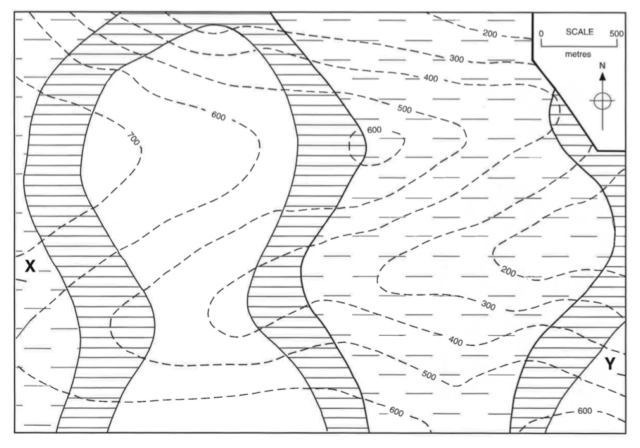

In [2]:
# Display map image
img = mpimg.imread("map4.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

In [4]:
# Read the topographic contours
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,2707.03,2761.08,200,POINT (2707.02600 2761.08200)
1,2754.92,2740.13,200,POINT (2754.92300 2740.13000)
2,2796.66,2725.60,200,POINT (2796.66400 2725.60100)
3,2854.29,2701.51,200,POINT (2854.28600 2701.51000)
4,2915.51,2684.03,200,POINT (2915.51400 2684.02500)


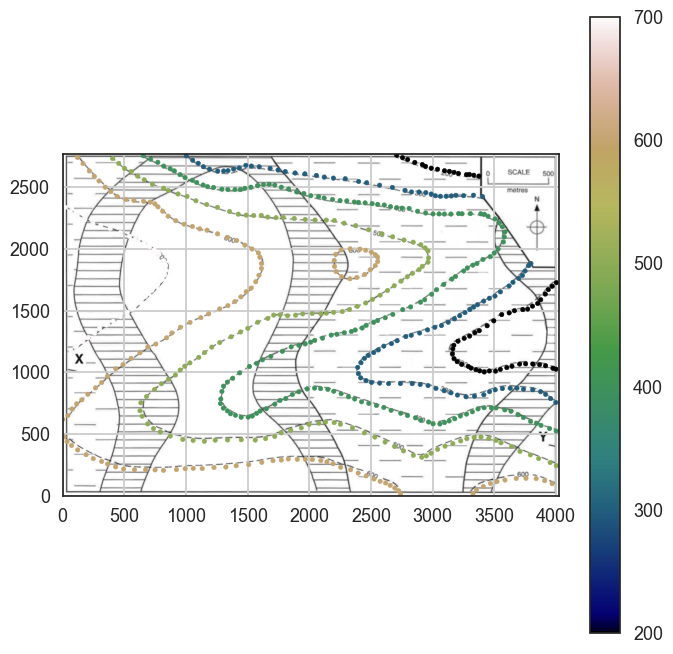

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 4020, 0, 2768], cmap="gray")
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True, markersize=10)
ax.set_ylim((0,2768))
ax.set_xlim((0,4020))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

In [6]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

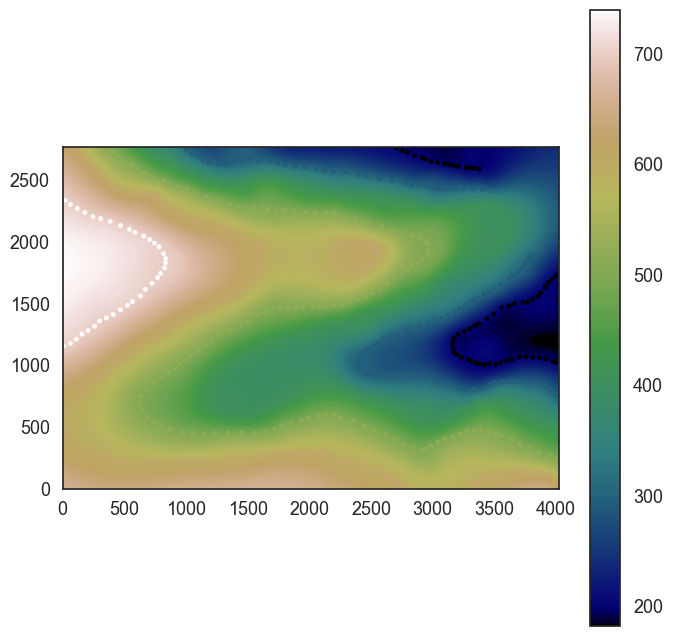

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth", markersize=10)
im = ax.imshow(topo_raster, origin="lower", extent=[0, 4020, 0, 2768], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map4.tif", 
                       extent=[0, 4020, 0, 2768], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map4.tif")

## 2. Stratigraphic boundaries or units' contacts

In [10]:
# Read the contacts. These are the bases of the units
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,741.78,307.08,A,POINT (741.78100 307.08100)
1,805.76,1010.18,A,POINT (805.75900 1010.18200)
2,504.36,2074.94,A,POINT (504.35500 2074.93700)
3,1143.31,2633.78,A,POINT (1143.31300 2633.77900)
4,1861.69,1931.02,A,POINT (1861.69300 1931.02400)


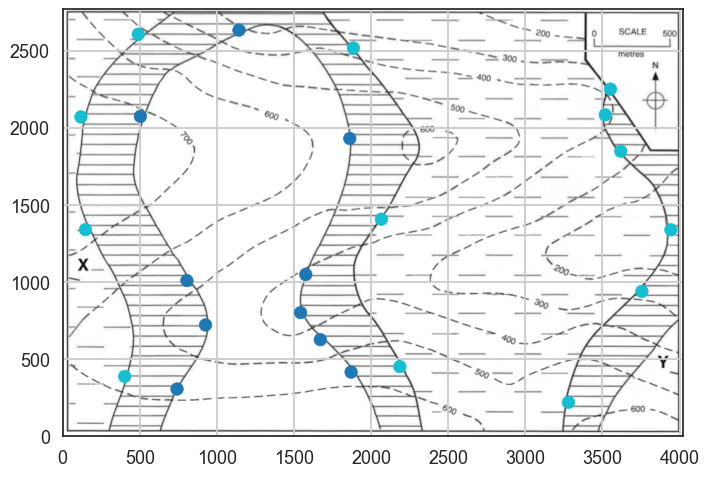

In [11]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 4020, 0, 2768], cmap="gray")
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,2768))
ax.set_xlim((0,4020))
ax.grid();

In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,741.78,307.08,A,POINT (741.78100 307.08100),565.29
1,805.76,1010.18,A,POINT (805.75900 1010.18200),526.48
2,504.36,2074.94,A,POINT (504.35500 2074.93700),707.98
3,1143.31,2633.78,A,POINT (1143.31300 2633.77900),322.97
4,1861.69,1931.02,A,POINT (1861.69300 1931.02400),583.97


### Strike lines

In [13]:
# Read the strike lines 
gdf = df_to_gdf(os.path.join("strike_lines", "strike_lines.txt"), sep="\t")
gdf.head()

,X,Y,Z,formation,id,geometry
0,848.63,935.15,500,A1,1,POINT (848.63000 935.15100)
1,857.85,2480.98,500,A1,1,POINT (857.84500 2480.97800)
2,681.96,2388.08,600,A1,2,POINT (681.95600 2388.07700)
3,686.82,1192.81,600,A1,2,POINT (686.81900 1192.80700)
4,1589.61,1086.55,400,A2,4,POINT (1589.61000 1086.54700)


In [14]:
# Convert the points into strike lines
# western contact of white and striped units
linestring_gdf_A1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "A1"])
# eastern contact of white and striped units
linestring_gdf_A2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "A2"])
# western contact of striped and dashed units
linestring_gdf_B1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B1"])
# contact between striped and dashed units in the middle of the map
linestring_gdf_B2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B2"])
# eastern contact between striped and dashed units
linestring_gdf_B3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "B3"])

In [15]:
# Check that the strike lines are valid
print("A1\n", linestring_gdf_A1.is_valid)
print("A2\n", linestring_gdf_A2.is_valid)
print("B1\n", linestring_gdf_B1.is_valid)
print("B2\n", linestring_gdf_B2.is_valid)
print("B3\n", linestring_gdf_B3.is_valid)

A1
 0    True
1    True
dtype: bool
A2
 0    True
1    True
dtype: bool
B1
 0    True
1    True
dtype: bool
B2
 0    True
1    True
dtype: bool
B3
 0    True
1    True
dtype: bool


In [16]:
# Calculate orientations 
orientations_A1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A1)
orientations_A2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A2)
orientations_B1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B1)
orientations_B2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B2)
orientations_B3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B3)
# print orientations
print(f"A1 dip = {orientations_A1.iloc[0,0]:.2f}, azimuth = {orientations_A1.iloc[0,1]:.2f}")
print(f"A2 dip = {orientations_A2.iloc[0,0]:.2f}, azimuth = {orientations_A2.iloc[0,1]:.2f}")
print(f"B1 dip = {orientations_B1.iloc[0,0]:.2f}, azimuth = {orientations_B1.iloc[0,1]:.2f}")
print(f"B2 dip = {orientations_B2.iloc[0,0]:.2f}, azimuth = {orientations_B2.iloc[0,1]:.2f}")
print(f"B3 dip = {orientations_B3.iloc[0,0]:.2f}, azimuth = {orientations_B3.iloc[0,1]:.2f}")

A1 dip = 31.48, azimuth = 90.13
A2 dip = 29.19, azimuth = 270.14
B1 dip = 30.36, azimuth = 90.18
B2 dip = 29.24, azimuth = 269.70
B3 dip = 31.61, azimuth = 89.20


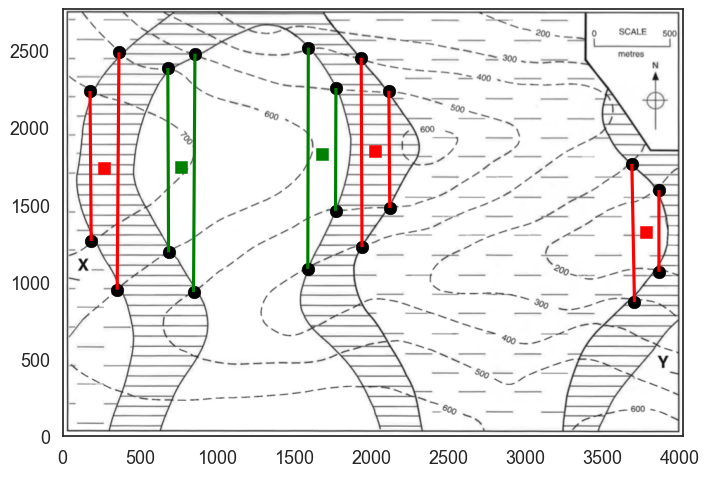

In [17]:
# Plot all this information on the map, squares are orientations
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 4020, 0, 2768], cmap="gray")
# plot points
gdf.plot(ax=ax, aspect="equal", color="black")
# plot strike lines
# western contact of white and striped units
linestring_gdf_A1.plot(ax=ax, aspect="equal", color="green")
orientations_A1.plot(ax=ax, aspect="equal", color="green", marker="s")
# eastern contact of white and striped units
linestring_gdf_A2.plot(ax=ax, aspect="equal", color="green")
orientations_A2.plot(ax=ax, aspect="equal", color="green", marker="s")
# western contact of striped and dashed units
linestring_gdf_B1.plot(ax=ax, aspect="equal", color="red")
orientations_B1.plot(ax=ax, aspect="equal", color="red", marker="s")
# contact between striped and dashed units in the middle of the map
linestring_gdf_B2.plot(ax=ax, aspect="equal", color="red")
orientations_B2.plot(ax=ax, aspect="equal", color="red", marker="s")
# eastern contact between striped and dashed units
linestring_gdf_B3.plot(ax=ax, aspect="equal", color="red")
orientations_B3.plot(ax=ax, aspect="equal", color="red", marker="s");

A1 and B1 dip 30 degrees to the east, whereas A2 and B2 dip 30 degrees to the west. This tell us that the structure in the west is a syncline (the beds dip towards the core of the structure). B3 dips 30 degrees to the east, this tells us that the structure in the east is an anticline (the beds dip away from the core of the structure). So, here we have a syncline-anticline pair.

In [18]:
# Merge orientations
orientations = pd.concat([orientations_A1, orientations_A2,orientations_B1,orientations_B2,orientations_B3]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,31.48,90.13,550.00,POINT (768.81250 1749.25325),1.00,768.81,1749.25,A1
1,0,29.19,270.14,450.00,POINT (1681.01900 1832.03700),1.00,1681.02,1832.04,A2
2,0,30.36,90.18,650.00,POINT (270.41675 1736.98775),1.00,270.42,1736.99,B1
3,0,29.24,269.70,450.00,POINT (2028.27100 1850.70800),1.00,2028.27,1850.71,B2
4,0,31.61,89.20,250.00,POINT (3782.75150 1325.33075),1.00,3782.75,1325.33,B3


In [19]:
# Rename the orientations as if they come from two units A and B
orientations["formation"] = ["A", "A", "B", "B", "B"]
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,31.48,90.13,550.00,POINT (768.81250 1749.25325),1.00,768.81,1749.25,A
1,0,29.19,270.14,450.00,POINT (1681.01900 1832.03700),1.00,1681.02,1832.04,A
2,0,30.36,90.18,650.00,POINT (270.41675 1736.98775),1.00,270.42,1736.99,B
3,0,29.24,269.70,450.00,POINT (2028.27100 1850.70800),1.00,2028.27,1850.71,B
4,0,31.61,89.20,250.00,POINT (3782.75150 1325.33075),1.00,3782.75,1325.33,B


## 3. Construction of the model in GemPy

In [20]:
# Create a geomodel object called model4
geo_model = gp.create_model("model4")

In [21]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 4020, 0, 2768, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [22]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,A,Default series,1,#015482,1
1,B,Default series,2,#9f0052,2


In [23]:
# The base of the lowermost unit C (dashed) does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("C")

# Group the surfaces as series Strata
gp.map_stack_to_surfaces(geo_model, {"Strata": ("A", "B","C"),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
0,A,Strata,1,#015482,1
1,B,Strata,2,#9f0052,2
2,C,Strata,3,#ffbe00,3


In [24]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,A,Strata,1,False,False,True,True,#015482,NaN,NaN,NaN,1,10,2
1,B,Strata,2,False,False,True,True,#9f0052,NaN,NaN,NaN,2,13,3
2,C,Strata,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3,0,0


In [25]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map4.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [26]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [27]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer="fast_compile");

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             4982.19
$C_o$           591005.33
drift equations       [3]


In [28]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

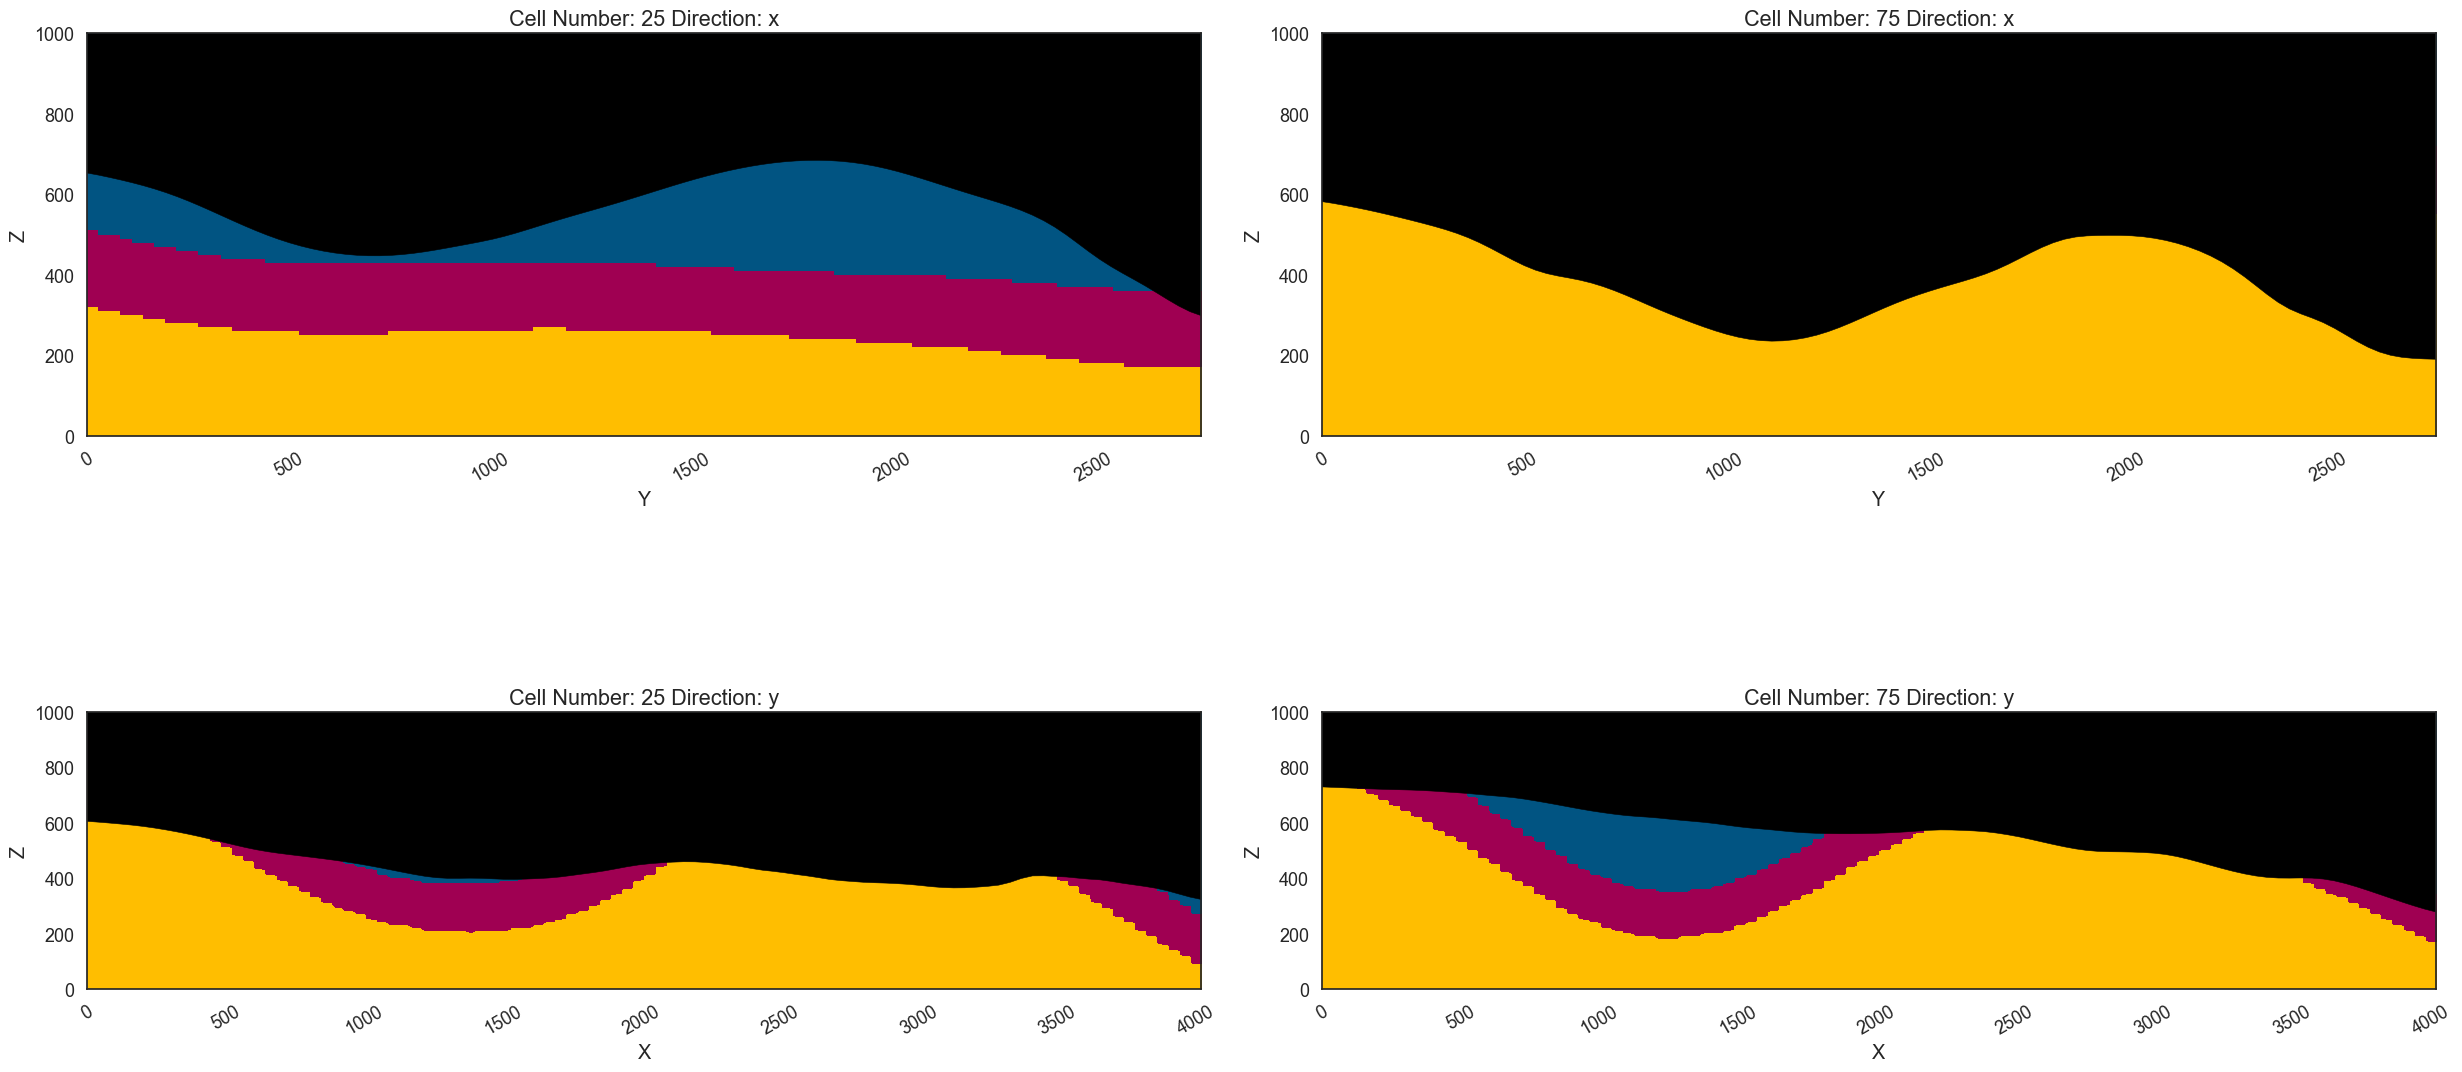

In [29]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [30]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);

We can see the syncline and anticline.